# Tahoe-x1 Model Tutorial

Run this notebook on a colab notebook with a free GPU:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Tahoe-x1-Tutorial.ipynb)

This tutorial demonstrates how to use the Tahoe-x1 foundation model for single-cell RNA-seq data. Tahoe-x1 is a transformer-based model that can extract both cell and gene embeddings from raw count data.

**What you'll learn in this notebook:**
- How to load and configure the Tahoe-x1 model
- Processing single-cell RNA-seq data for Tahoe
- Extracting cell embeddings
- Extracting gene embeddings
- Visualizing embeddings with UMAP
- Extracting attention weights for interpretability

For more examples, check out our [GitHub](https://github.com/helicalAI/helical) and [documentation](https://helical.readthedocs.io/).

## Installation

Install or update Helical to get access to the Tahoe model:

In [ ]:
!pip install helical --upgrade

## Imports and Setup

In [14]:
import logging
import warnings
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset

# Configure logging
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings("ignore")

# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Load Example Dataset

We'll use the human fetal yolk sac scRNA-seq dataset from Helical's Hugging Face repository:

In [15]:
# Load dataset from Hugging Face
dataset = load_dataset(
    "helical-ai/yolksac_human", 
    split="train[:10%]", 
    trust_remote_code=True, 
    download_mode="reuse_cache_if_exists"
)

# Store labels for visualization later
labels = dataset["LVL1"]

print(f"Loaded {len(dataset)} cells")

Generating test split: 100%|██████████| 6336/6336 [00:02<00:00, 2617.09 examples/s]

Loaded 2534 cells


## Convert to AnnData Format

Tahoe works with AnnData objects, the standard format for single-cell data in Python:

In [16]:
from helical.utils import get_anndata_from_hf_dataset

ann_data = get_anndata_from_hf_dataset(dataset)
print(ann_data)

# For this tutorial, let's use a subset for faster processing
ann_data_subset = ann_data[:500]  # Use first 500 cells
labels_subset = labels[:500]
print(f"\nUsing subset: {ann_data_subset.n_obs} cells, {ann_data_subset.n_vars} genes")

AnnData object with n_obs × n_vars = 2534 × 37318
    obs: 'LVL1', 'LVL2', 'LVL3'
    var: 'gene_name'

Using subset: 500 cells, 37318 genes


## Initialize Tahoe Model

Tahoe comes in three sizes (70m, 1b, 3b). Currently, the 70m model is available. The model uses Flash Attention by default for efficient inference.

In [17]:
from helical.models.tahoe import Tahoe, TahoeConfig

# Configure the Tahoe model
tahoe_config = TahoeConfig(
    model_size="70m",  # 12-layer transformer with 512 embedding dimensions
    batch_size=8,      # Adjust based on your GPU memory
    device=device,
)

# Initialize the model (will download weights on first use)
tahoe = Tahoe(configurer=tahoe_config)

print("\nTahoe model loaded successfully!")

2025-11-21 14:54:50,957 - INFO:helical.models.tahoe.model:Loading Tahoe model (size: 70m) from Hugging Face...
2025-11-21 14:54:51,697 - INFO:helical.models.tahoe.tahoe_x1.model.model:MosaicML recommends using config.init_device="meta" with Composer + FSDP for faster initialization.
2025-11-21 14:54:52,499 - INFO:helical.models.tahoe.model:Model loaded with 12 transformer layers.
2025-11-21 14:54:52,501 - INFO:helical.models.tahoe.model:Tahoe model is in 'eval' mode, on device 'cuda' with embedding mode 'cell' and attention implementation 'flash'.



Tahoe model loaded successfully!


## Process Data

Tahoe requires gene names to be mapped to Ensembl IDs. The `process_data` method handles this automatically:

In [18]:
# Process data - this will map gene symbols to Ensembl IDs
dataloader = tahoe.process_data(
    ann_data_subset,
    gene_names="gene_name",  # Column containing gene symbols
    use_raw_counts=True
)

print("Data processed and ready for inference!")

2025-11-21 14:54:52,511 - INFO:helical.models.tahoe.model:Processing data for Tahoe.
2025-11-21 14:54:52,673 - INFO:helical.utils.mapping:Mapped 20969 / 37318 genes to Ensembl IDs.
2025-11-21 14:54:52,689 - INFO:helical.models.tahoe.model:Matched 20865/37318 genes in vocabulary of size 62720.
2025-11-21 14:54:52,709 - INFO:helical.models.tahoe.model:Successfully processed the data for Tahoe.


Data processed and ready for inference!


## Extract Cell Embeddings

Cell embeddings capture the transcriptional state of each cell in a dense vector representation:

In [19]:
# Get cell embeddings
cell_embeddings = tahoe.get_embeddings(dataloader)

print(f"Cell embeddings shape: {cell_embeddings.shape}")
print(f"Each cell is represented by a {cell_embeddings.shape[1]}-dimensional vector")

2025-11-21 14:54:52,726 - INFO:helical.models.tahoe.model:Extracting embeddings from Tahoe model...
Embedding cells: 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]

Cell embeddings shape: (500, 512)
Each cell is represented by a 512-dimensional vector


## Visualize Cell Embeddings with UMAP

Let's visualize the cell embeddings in 2D using UMAP to see how cells cluster by cell type:

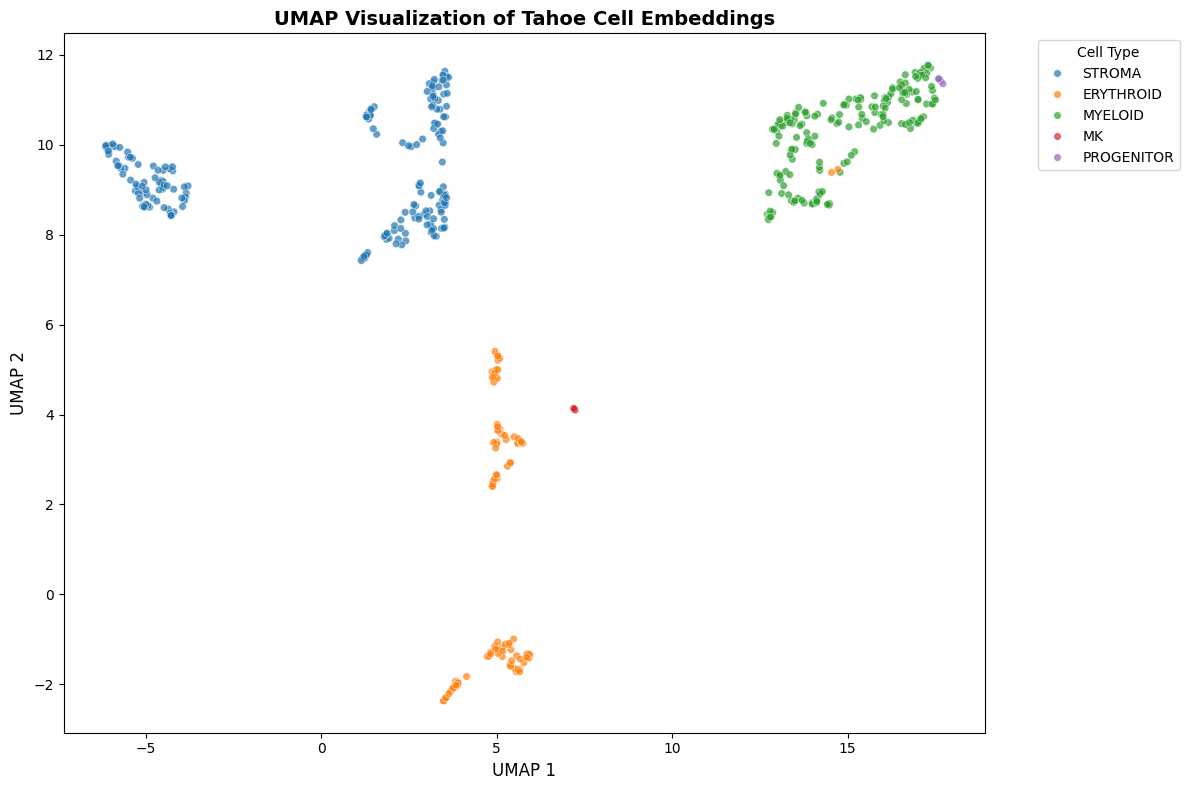

In [20]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce dimensionality with UMAP
reducer = umap.UMAP(min_dist=0.1, n_components=2, n_neighbors=15, random_state=42)
umap_embedding = reducer.fit_transform(cell_embeddings)

# Create plot dataframe
plot_df = pd.DataFrame(umap_embedding, columns=['UMAP1', 'UMAP2'])
plot_df['Cell Type'] = labels_subset

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=plot_df, 
    x='UMAP1', 
    y='UMAP2', 
    hue='Cell Type',
    palette='tab10',
    s=30,
    alpha=0.7
)
plt.title('UMAP Visualization of Tahoe Cell Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cell Type')
plt.tight_layout()
plt.show()

## Extract Gene Embeddings

Tahoe can also extract gene embeddings for each cell. Gene embeddings are returned as a **list of pandas Series** (one per cell), where each Series contains the embeddings for genes expressed in that specific cell:

In [21]:
# Get both cell and gene embeddings
cell_embeddings, gene_embeddings = tahoe.get_embeddings(
    dataloader,
    return_gene_embeddings=True
)

print(f"Cell embeddings shape: {cell_embeddings.shape}")
print(f"Gene embeddings: {len(gene_embeddings)} cells (list of pandas Series)")
print(f"\nFirst cell has {len(gene_embeddings[0])} genes expressed")

# Get first gene embedding from first cell
first_gene_embedding = gene_embeddings[0].iloc[0]
print(f"Each gene has a {len(first_gene_embedding)}-dimensional embedding")

print(f"\nExample - First 5 genes in first cell:")
for gene_id, embedding in list(gene_embeddings[0].items())[:5]:
    print(f"  {gene_id}: shape {embedding.shape}")

2025-11-21 14:54:58,272 - INFO:helical.models.tahoe.model:Extracting embeddings from Tahoe model...
Embedding cells: 100%|██████████| 63/63 [00:11<00:00,  5.25it/s]


Cell embeddings shape: (500, 512)
Gene embeddings: 500 cells (list of pandas Series)

First cell has 2048 genes expressed
Each gene has a 512-dimensional embedding

Example - First 5 genes in first cell:
  <cls>: shape (512,)
  ENSG00000180182: shape (512,)
  ENSG00000167393: shape (512,)
  ENSG00000089234: shape (512,)
  ENSG00000162545: shape (512,)


## Visualize Gene Embeddings

Gene embeddings are returned as a list of pandas Series (one per cell), where each Series contains gene embeddings for genes expressed in that cell. Let's aggregate and visualize them:

Aggregated gene embeddings for 14801 unique genes
Embedding shape: (14801, 512)


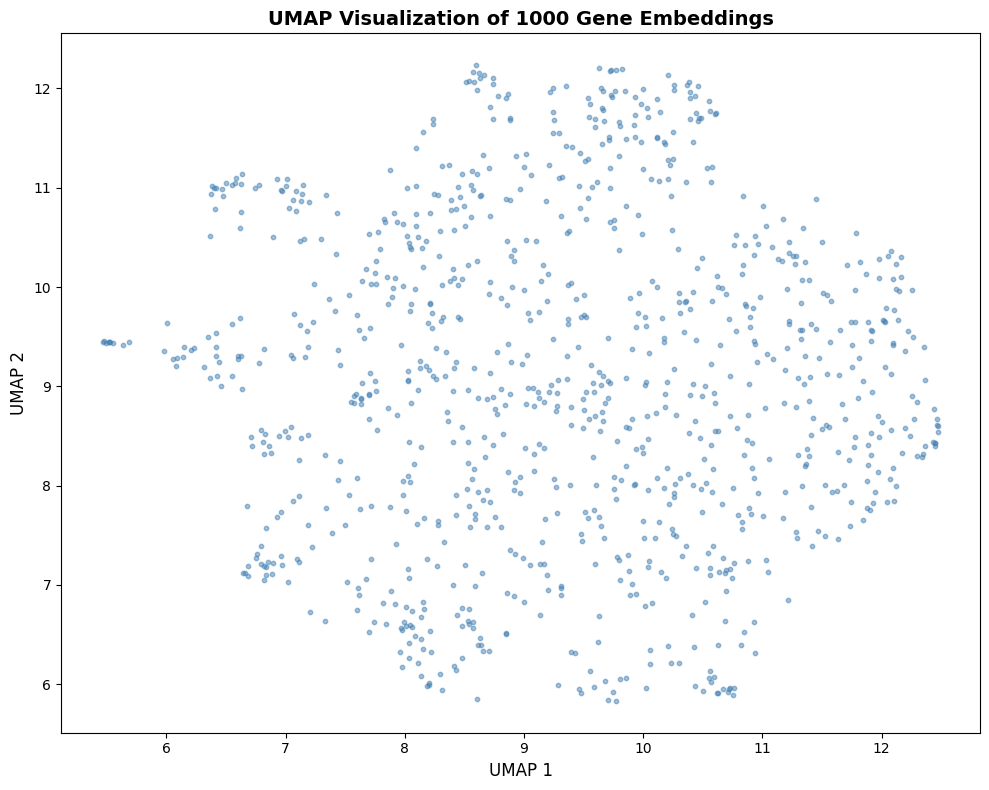


You can access gene embeddings for a specific cell:
Example: gene_embeddings[0]['<cls>']  # First cell, specific gene


In [22]:
# Aggregate gene embeddings across all cells (average per gene)
from collections import defaultdict

gene_embedding_accumulator = defaultdict(lambda: {'sum': None, 'count': 0})

# Accumulate embeddings for each gene across all cells
for cell_series in gene_embeddings:
    for gene_id, embedding in cell_series.items():
        if gene_embedding_accumulator[gene_id]['sum'] is None:
            gene_embedding_accumulator[gene_id]['sum'] = embedding.copy()
        else:
            gene_embedding_accumulator[gene_id]['sum'] += embedding
        gene_embedding_accumulator[gene_id]['count'] += 1

# Average the embeddings
aggregated_gene_embeddings = {}
for gene_id, data in gene_embedding_accumulator.items():
    aggregated_gene_embeddings[gene_id] = data['sum'] / data['count']

print(f"Aggregated gene embeddings for {len(aggregated_gene_embeddings)} unique genes")

# Convert to numpy array for visualization
gene_names = list(aggregated_gene_embeddings.keys())
gene_embeddings_array = np.stack(list(aggregated_gene_embeddings.values()))

print(f"Embedding shape: {gene_embeddings_array.shape}")

# Visualize a subset of genes with UMAP
n_genes_to_plot = min(1000, len(gene_names))
gene_subset_idx = np.random.choice(len(gene_names), n_genes_to_plot, replace=False)
gene_subset = gene_embeddings_array[gene_subset_idx]

# UMAP for genes
gene_reducer = umap.UMAP(min_dist=0.1, n_components=2, n_neighbors=15, random_state=42)
gene_umap = gene_reducer.fit_transform(gene_subset)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(gene_umap[:, 0], gene_umap[:, 1], s=10, alpha=0.5, c='steelblue')
plt.title(f'UMAP Visualization of {n_genes_to_plot} Gene Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nYou can access gene embeddings for a specific cell:")
print(f"Example: gene_embeddings[0]['{gene_names[0]}']  # First cell, specific gene")

## Extract Attention Weights

For interpretability, you can extract attention weights from the transformer layers. This requires using the PyTorch attention implementation instead of Flash Attention.

**Note:** This is slower and uses more memory than the default Flash Attention.

In [23]:
# Create a new model with torch attention implementation
tahoe_config_attn = TahoeConfig(
    model_size="70m",
    batch_size=4,  # Reduce batch size for memory efficiency
    device=device,
    attn_impl='torch'  # Required for attention extraction
)

tahoe_attn = Tahoe(configurer=tahoe_config_attn)
print("Tahoe model with attention extraction loaded!")

2025-11-21 14:55:13,026 - INFO:helical.models.tahoe.model:Loading Tahoe model (size: 70m) from Hugging Face...
2025-11-21 14:55:13,744 - INFO:helical.models.tahoe.tahoe_x1.model.model:MosaicML recommends using config.init_device="meta" with Composer + FSDP for faster initialization.
2025-11-21 14:55:14,558 - INFO:helical.models.tahoe.model:Model loaded with 12 transformer layers.
2025-11-21 14:55:14,559 - INFO:helical.models.tahoe.model:Tahoe model is in 'eval' mode, on device 'cuda' with embedding mode 'cell' and attention implementation 'torch'.


Tahoe model with attention extraction loaded!


In [24]:
# Process a smaller subset for attention extraction
ann_data_tiny = ann_data[:50]  # Use only 50 cells

dataloader_attn = tahoe_attn.process_data(
    ann_data_tiny,
    gene_names="gene_name",
    use_raw_counts=True
)

2025-11-21 14:55:14,568 - INFO:helical.models.tahoe.model:Processing data for Tahoe.
2025-11-21 14:55:14,731 - INFO:helical.utils.mapping:Mapped 20969 / 37318 genes to Ensembl IDs.
2025-11-21 14:55:14,748 - INFO:helical.models.tahoe.model:Matched 20865/37318 genes in vocabulary of size 62720.
2025-11-21 14:55:14,768 - INFO:helical.models.tahoe.model:Successfully processed the data for Tahoe.


In [25]:
# Extract attention weights
cell_embeddings_attn, attention_weights = tahoe_attn.get_embeddings(
    dataloader_attn, 
    output_attentions=True
)

print(f"Cell embeddings shape: {cell_embeddings_attn.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"\nAttention weights dimensions: (n_cells, n_heads, seq_length, seq_length)")

2025-11-21 14:55:14,782 - INFO:helical.models.tahoe.model:Extracting embeddings from Tahoe model...
Embedding cells: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Cell embeddings shape: (50, 512)
Attention weights shape: (50, 8, 2048, 2048)

Attention weights dimensions: (n_cells, n_heads, seq_length, seq_length)


## Visualize Attention Patterns

Let's visualize the attention pattern for one cell to see which genes the model pays attention to:

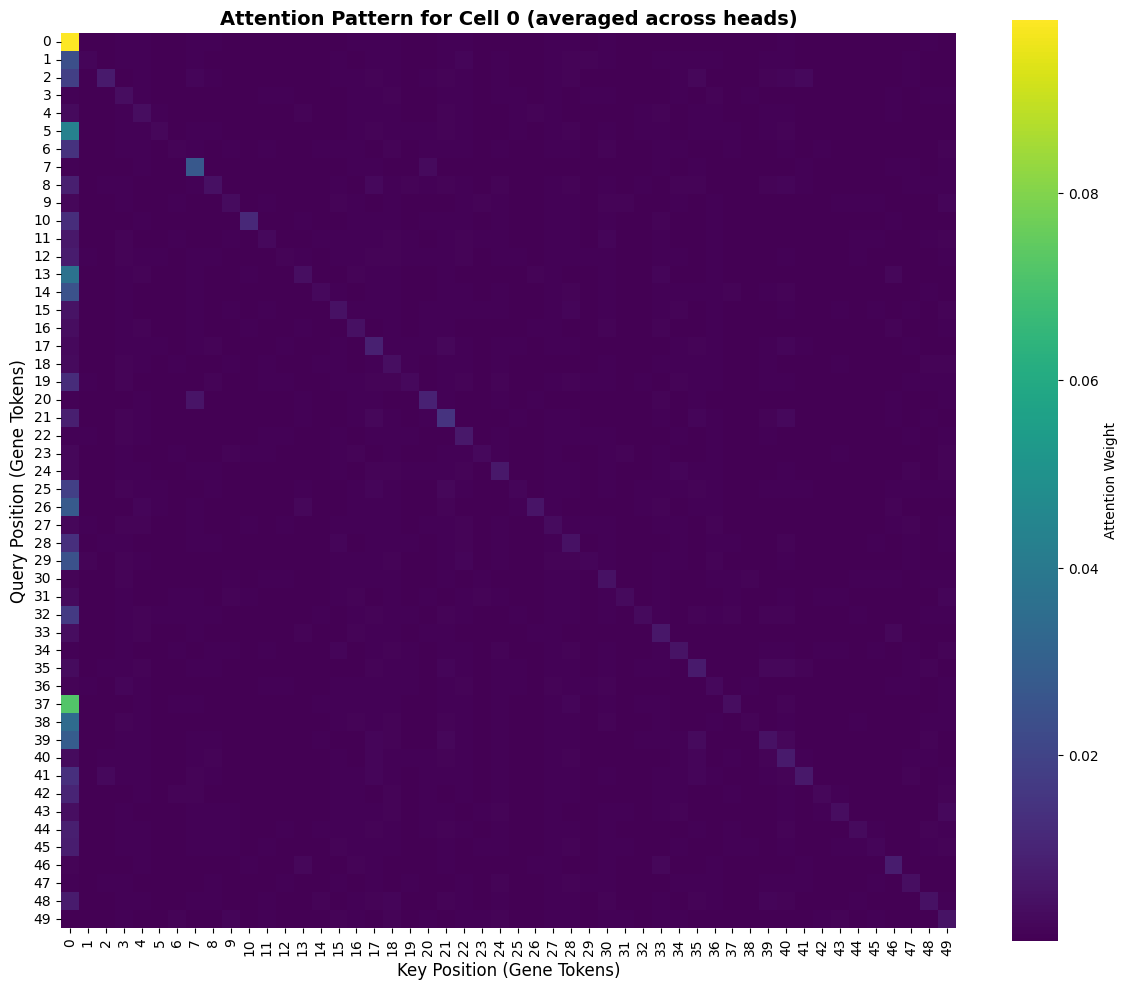

Showing first 50x50 positions of 2048 total sequence length


In [26]:
# Select first cell and average across attention heads
cell_idx = 0
cell_attention = attention_weights[cell_idx]  # Shape: (n_heads, seq_len, seq_len)

# Average across heads
avg_attention = cell_attention.mean(axis=0)  # Shape: (seq_len, seq_len)

# Find actual sequence length (excluding padding)
non_zero_mask = avg_attention.sum(axis=1) > 0
actual_seq_len = non_zero_mask.sum()
avg_attention_trimmed = avg_attention[:actual_seq_len, :actual_seq_len]

# Plot attention heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    avg_attention_trimmed[:50, :50],  # Show first 50x50 for visibility
    cmap='viridis',
    square=True,
    cbar_kws={'label': 'Attention Weight'}
)
plt.title(f'Attention Pattern for Cell {cell_idx} (averaged across heads)', fontsize=14, fontweight='bold')
plt.xlabel('Key Position (Gene Tokens)', fontsize=12)
plt.ylabel('Query Position (Gene Tokens)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Showing first 50x50 positions of {actual_seq_len} total sequence length")

In [ ]:
# Get transformer embeddings with their corresponding gene IDs
# This ensures we know which embedding corresponds to which gene
transformer_embs, gene_ids = tahoe.get_transformer_embeddings(dataloader)

print(f"Number of cells: {len(transformer_embs)}")
print(f"First cell embeddings shape: {transformer_embs[0].shape}")
print(f"First cell gene IDs shape: {gene_ids[0].shape}")
print(f"Embedding dimension: {transformer_embs[0].shape[1]}")

# Show the gene mapping for first cell
pad_token_id = tahoe.collator_cfg["pad_token_id"]
idx_to_gene = tahoe.vocab.index_to_token

print(f"\nFirst cell - first 5 non-padding genes:")
count = 0
for pos in range(len(gene_ids[0])):
    if gene_ids[0][pos] != pad_token_id and count < 5:
        gene_name = idx_to_gene[gene_ids[0][pos]]
        print(f"  Position {pos}: {gene_name} (ID: {gene_ids[0][pos]})")
        count += 1

# Optional: Modify embeddings for perturbation experiments
# Example - perturb gene at position 5 in first cell
# transformer_embs[0][5, :] += np.random.randn(transformer_embs[0].shape[1]) * 0.1

# Decode embeddings to predicted expression
# Returns a list of pandas Series (one per cell)
expr_predictions = tahoe.decode_embeddings(transformer_embs, gene_ids)

print(f"\nNumber of cells with predictions: {len(expr_predictions)}")
print(f"First cell has predictions for {len(expr_predictions[0])} genes")

# Show predictions for first cell, first 5 genes
print(f"\nFirst cell - predicted expression for first 5 genes:")
for gene_name, pred_expr in list(expr_predictions[0].items())[:5]:
    print(f"  {gene_name}: {pred_expr:.4f}")

## Expression Prediction with Decoder

Tahoe includes an expression decoder that can predict gene expression values from embeddings. This is useful for:
- **In-silico perturbation**: Modify gene embeddings and predict resulting expression changes
- **Counterfactual analysis**: Answer "what if" questions about gene regulation
- **Expression imputation**: Predict expression from partial or modified embeddings

## Summary

In this notebook, you learned how to:

1. ✅ Load and configure the Tahoe-x1 model for single-cell RNA-seq analysis
2. ✅ Process scRNA-seq data with automatic gene symbol to Ensembl ID mapping
3. ✅ Extract cell embeddings that capture cellular states
4. ✅ Extract gene embeddings per cell (list of pandas Series, one per cell)
5. ✅ Visualize embeddings using UMAP for exploratory analysis
6. ✅ Extract and visualize attention weights for model interpretability
7. ✅ Use the expression decoder for predicting expression from embeddings

### Key Features

- **Cell embeddings**: Dense vector representations capturing cellular transcriptional states (numpy array)
- **Gene embeddings**: List of pandas Series, one per cell. Each Series contains gene embeddings indexed by Ensembl IDs for genes expressed in that cell
- **Attention weights**: Interpretable attention patterns (requires `attn_impl='torch'`)
- **Expression decoder**: Predict gene expression values from embeddings (useful for perturbation experiments)

### Gene Embeddings Structure

```python
# gene_embeddings is a list with length = number of cells
len(gene_embeddings)  # e.g., 500 cells

# Each element is a pandas Series for that cell
gene_embeddings[0]  # pandas Series with gene IDs as keys

# Access specific gene in specific cell
gene_embeddings[0]['ENSG00000123456']  # numpy array of shape (embedding_dim,)
```

### Next Steps

- **Cell Type Annotation**: Use the embeddings for downstream tasks like cell type classification
- **Gene Analysis**: Analyze gene expression patterns using per-cell gene embeddings
- **Perturbation Experiments**: Use the decoder to predict expression changes from modified embeddings
- **Integration**: Combine Tahoe embeddings with other analysis tools in the scRNA-seq ecosystem
- **Fine-tuning**: Adapt the model for specific downstream tasks (see other notebooks)

### Model Information

- **Model**: Tahoe-x1 by Tahoe Therapeutics
- **Hugging Face**: [tahoebio/Tahoe-x1](https://huggingface.co/tahoebio/Tahoe-x1)
- **Architecture**: Transformer-based foundation model for scRNA-seq
- **Available sizes**: 70m (12 layers, 512d), 1b (24 layers, 1024d), 3b (36 layers, 1536d)

For more information and examples, visit the [Helical documentation](https://helical.readthedocs.io/).